In [1]:
import pandas as pd

# Load the dataset
# df_last_decade = pd.read_csv('your_data_file.csv')
df_last_decade = pd.read_csv('merged_dataset_2000_2010.csv')
# Convert 'year_of_interview' to datetime
df_last_decade['year_of_interview'] = pd.to_datetime(df_last_decade['year_of_interview'], format='%Y')

# Extract year from 'year_of_interview'
df_last_decade['year'] = df_last_decade['year_of_interview'].dt.year

# Convert 'partners_lifetime' to numeric
df_last_decade['partners_lifetime'] = pd.to_numeric(df_last_decade['partners_lifetime'], errors='coerce')

#### 1. Data Cleaning

In [ ]:
# Check for missing values
print("Checking for missing values:")
print(df_last_decade.isnull().sum())

# Drop rows with missing 'partners_lifetime' data
df_last_decade = df_last_decade.dropna(subset=['partners_lifetime'])

# Confirm removal of missing values
print("Data after removing rows with missing 'partners_lifetime':")
print(df_last_decade.isnull().sum())

# Display the cleaned dataset's first few rows to inspect
print("First few rows of the cleaned dataset:")
print(df_last_decade.head())


### 2. Removing Outliers

In [2]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]
    return df_no_outliers

# Remove outliers from 'partners_lifetime'
df_no_outliers = remove_outliers_iqr(df_last_decade, 'partners_lifetime')

# Check the number of data points before and after removing outliers
print("Number of data points before removing outliers:", len(df_last_decade))
print("Number of data points after removing outliers:", len(df_no_outliers))


Number of data points before removing outliers: 27272
Number of data points after removing outliers: 24367


### Normality Tests

In [18]:
from scipy.stats import kstest, anderson

# Perform Kolmogorov-Smirnov test
ks_stat, ks_p_value = kstest(df_no_outliers['partners_lifetime'], 'norm')
print(f"Kolmogorov-Smirnov test for normality: Statistic={ks_stat}, p-value={ks_p_value}")




Kolmogorov-Smirnov test for normality: Statistic=0.7680078560123194, p-value=0.0


### 3. Data Aggregation

In [11]:
# Aggregate data
average_partners = df_last_decade.groupby(['year', 'gender'])[['partners_lifetime']].mean().reset_index()

# Pivot the data for easier plotting
trend_pivot = average_partners.pivot_table(index='year', columns='gender', values='partners_lifetime')
print(trend_pivot)


gender         0          1
year                       
1999    6.909601  12.527826
2000    7.106710  13.042099
2001    4.940887  12.143460
2010    7.150461  16.756522
2011    7.813023  13.979467
2012    7.084223  13.149247


### 4. Visualization of Trends

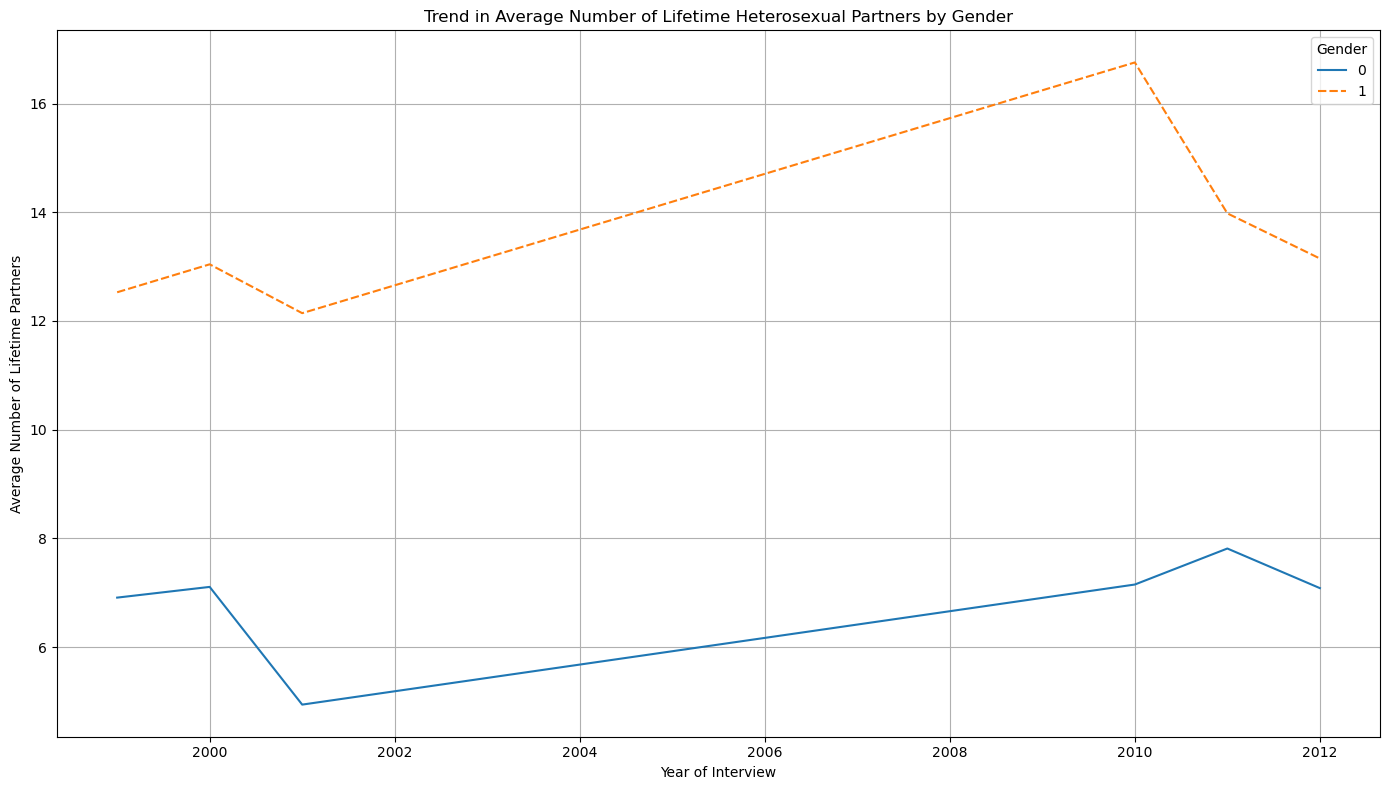

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting trends
plt.figure(figsize=(14, 8))

sns.lineplot(data=trend_pivot)
plt.title('Trend in Average Number of Lifetime Heterosexual Partners by Gender')
plt.xlabel('Year of Interview')
plt.ylabel('Average Number of Lifetime Partners')
plt.legend(title='Gender')
plt.grid(True)

plt.tight_layout()
plt.show()

### 5. Regression Analysis
To understand the trend in the number of lifetime partners over the years, we will perform linear regression for each gender.

In [16]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare data for regression
years_numeric = np.array(trend_pivot.index).reshape(-1, 1)

# Define a function to perform regression and print results
def perform_regression(data, column_name):
    print(f"\nRegression analysis for {column_name}:")
    for gender in [0, 1]:
        subset = data[data['gender'] == gender]
        X = subset[['year']]
        y = subset[column_name]
        
        model = LinearRegression().fit(X, y)
        print(f"{gender} {column_name} Trend: Coefficient={model.coef_[0]:.2f}, Intercept={model.intercept_:.2f}")

# Perform regression for lifetime partners
perform_regression(average_partners, 'partners_lifetime')


Regression analysis for partners_lifetime:
0 partners_lifetime Trend: Coefficient=0.08, Intercept=-154.93
1 partners_lifetime Trend: Coefficient=0.16, Intercept=-310.24
